# Smart Beta and Factor Investing

This assignment refers to the HBS case: **Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

# 1. READING

1. Describe how each of the factors (other than MKT) is measured.1That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

1. Is the factor portfolio...
    * long-only
    * long-short
    * value-weighted
    * equally-weighted

1. What steps are taken in the factor construction to try to reduce the correlation between the factors?
5. What is the point of figures 1-6?
6. How is a “smart beta” ETF different from a traditional ETF?
7. Is it possible for all investors to have exposure to the “value” factor?
8. How does factor investing differ from traditional diversification?

#### Footnote:

If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

***

# 2. The Factors

### Data
Use the data found in `data/factor_pricing_data.xlsx`.

Factors: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.

* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.

* The sheet also contains data on five additional factors.

* All factor data is already provided as excess returns

### 1. 
Analyze the factors, similar to how you analyzed the three Fama-French factors in `Homework 4`.

You now have three additional factors, so let’s compare there univariate statistics. 

* mean
* volatility    
* Sharpe

In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel("factor_pricing_data_monthly.xlsx", sheet_name="factors (excess returns)", index_col=0)
df.index = pd.to_datetime(df.index)

sr_mean = df.mean() * 12
sr_vol = df.std() * np.sqrt(12)
sr_shp = sr_mean / sr_vol

df_sta = pd.DataFrame({"mean":sr_mean,
                        "volatility":sr_vol,
                        "sharpe": sr_shp})

df_sta

,mean,volatility,sharpe
MKT,0.087552,0.156142,0.560718
SMB,0.006120,0.101274,0.060435
HML,0.026039,0.108835,0.239249
RMW,0.044047,0.082931,0.531132
CMA,0.028288,0.072480,0.390284
UMD,0.060313,0.153352,0.393299


### 2. 

Based on the factor statistics above, answer the following.
* Does each factor have a positive risk premium (positive expected excess return)? 
* How have the factors performed since the time of the case, (2015-present)?


In [3]:
df_case = df.loc["2015-01-01":]

sr_mean_case = df_case.mean() * 12
sr_vol_case = df_case.std() * np.sqrt(12)
sr_shp_case = sr_mean_case / sr_vol_case

df_sta_case = pd.DataFrame({"mean":sr_mean_case,
                        "volatility":sr_vol_case,
                        "sharpe": sr_shp_case})

df_sta_case

,mean,volatility,sharpe
MKT,0.117872,0.157356,0.749078
SMB,-0.023775,0.103166,-0.230455
HML,-0.016303,0.129885,-0.125520
RMW,0.040012,0.072632,0.550896
CMA,-0.009141,0.082072,-0.111373
UMD,0.020119,0.137387,0.146438


Answer to Question 2:

- Yes.

- MKT, RMW, UMD have positive risk premium. Others don't.

### 3. 

Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

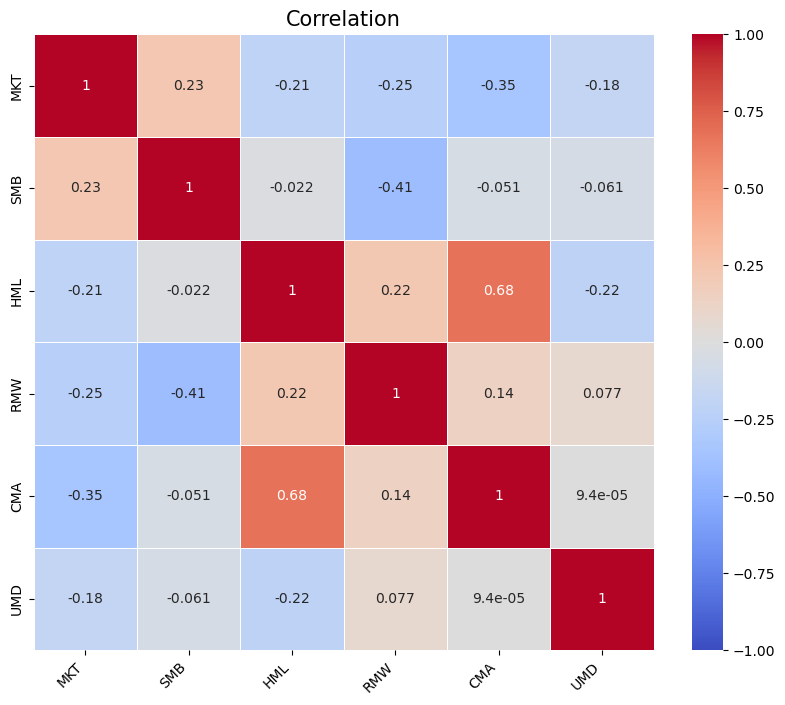

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_corr = df.corr()

plt.figure(figsize=(10, 8))  # 设置画布大小

# 绘制热力图（核心代码）
sns.heatmap(
    df_corr,
    annot=True,        
    cmap='coolwarm',    
    vmin=-1, vmax=1,    
    center=0,           
    linewidths=0.5,     
    # cbar_kws={'label': 'Corr'}  
)

plt.title('Correlation', fontsize=15)  
plt.xticks(rotation=45, ha='right') 
# plt.tight_layout() 

plt.show()

Answer:

- The correlations are not very big.

- Although HML has a high correlation with CMA, it has low correlation with other factors.




### 4. 

Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

MKT    0.218650
SMB    0.066849
HML   -0.021212
RMW    0.301829
CMA    0.321431
UMD    0.112453
Name: weights, dtype: float64


<Axes: >

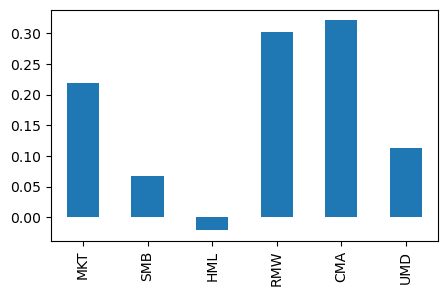

In [5]:
from scipy.optimize import minimize

# sr_mean = rets.mean()
# df_cov = rets.cov()
# rf = 0
# n_assets = rets.shape[1]

def optimized_weights(df_rets,dropna=True,scale_cov=1):
    if dropna:
        df_rets = df_rets.dropna()

    covmat_full = df_rets.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,df_rets.mean())
    weights = weights / weights.sum()

    if df_rets.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, index=df_rets.columns, columns=['weights'])

df_weights_unbounded = optimized_weights(df)['weights']
print(df_weights_unbounded)

plt.figure(figsize=(5,3))
df_weights_unbounded.plot.bar()

Answer:

- HML seems to be the least important and CMA and PMW are most important ones.

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

Our labeling of the last model as the **AQR** is just for concreteness. The firm is well-known for these factors and an unused case study discusses that further.

For instance, for the AQR model is...

$$
\mathbb{E}[\tilde{r}^i] 
= \beta^{i,\mathrm{MKT}} \, \mathbb{E}[\tilde{f}^{\mathrm{MKT}}] 
+ \beta^{i,\mathrm{HML}} \, \mathbb{E}[\tilde{f}^{\mathrm{HML}}] 
+ \beta^{i,\mathrm{RMW}} \, \mathbb{E}[\tilde{f}^{\mathrm{RMW}}] 
+ \beta^{i,\mathrm{UMD}} \, \mathbb{E}[\tilde{f}^{\mathrm{UMD}}]
$$

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

$$
\tilde{r}^i_t 
= \alpha^i 
+ \beta^{i,\mathrm{MKT}} \tilde{f}^{\mathrm{MKT}}_t 
+ \beta^{i,\mathrm{HML}} \tilde{f}^{\mathrm{HML}}_t 
+ \beta^{i,\mathrm{RMW}} \tilde{f}^{\mathrm{RMW}}_t 
+ \beta^{i,\mathrm{UMD}} \tilde{f}^{\mathrm{UMD}}_t 
+ \varepsilon_t
$$

### Data

* Monthly excess return data on `n=49` equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . .$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

### 1. 

Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

For each regression, report the estimated α and r-squared.

In [ ]:
df_port = pd.read_excel("factor_pricing_data_monthly.xlsx", index_col=0, sheet_name="portfolios (excess returns)")
df_port.index = pd.to_datetime(df_port.index)

import statsmodels.api as sm

for sector in df_port.columns:
    y = df_port[sector]
    x = df[["MKT", "HML", "RMW", "UMD"]]
    x = sm.add_constant(x)

    model = sm.OLS(y, x).fit()
    residuals = model.resid

    

In [9]:
df.columns

Index(['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'UMD'], dtype='object')



### 2. 

Calculate the mean-absolute-error of the estimated alphas.

$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|\tilde{\alpha}^i|$$

* If the pricing model worked, should these alpha estimates be large or small? Why?

* Based on your MAE stat, does this seem to support the pricing model or not?

### 2. 

Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?
   
### 3. 

Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

### 4. 

This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

### 5. 

We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?4
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

#### Footnote:

Recall that we found in `Homework 4` that the market premium went from being strongly positive to strongly negative when estimated in the cross-section.

***